## **Dataset unzip and save to the Drive folder**

In [ ]:
# Dataset unzip in the folder for processing (One time process) uncomment for unzip
# !unzip /content/drive/MyDrive/keypoint_detection/kaggle_facial_keypoint_dataset.zip -d /content/drive/MyDrive/keypoint_detection/


In [ ]:
# ! pip install seedir
# import seedir as sd
# sd.seedir('/content/drive/MyDrive/keypoint_detection/', style ='spaces')

## **Mount Google Drive**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if the file exists
# !ls
# !ls "/content/drive/MyDrive/keypoint_detection/"

In [ ]:
# datapath
# /content/drive/Mydrive/keypoint_detection/

## **Required libraries and packages import**

In [ ]:
# imports for the development of network and training and testing pipeline
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import cv2  # OpenCV
import numpy as np
# Function to show images in the notebook
%matplotlib inline
print(tf.__version__) # tensorflow version check
print("GPU Available: ", tf.config.list_physical_devices('GPU')) # GPU availability check


2.15.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Preparing data for model building**

In [ ]:
# Function to load images and keypoints from a directory
def load_images_and_keypoints(directory_path, csv_file_path):
    image_data = []
    keypoints_data = []

    # Load CSV file with keypoints information
    keypoints_df = pd.read_csv(csv_file_path)
    files = os.listdir(directory_path)
    files.sort(key=lambda x: int(x.split('.')[0])) # sorting files in a sequence
    # print (files)

    for filename in files:
        if filename.endswith(".jpg"):  # Adjust the file extension based on your image format
            img_path = os.path.join(directory_path, filename)
            img = cv2.imread(img_path)
            # print(img.shape)
            img = cv2.resize(img, (96, 96))  # Adjust the size as needed
            image_data.append(img)

            # Extract keypoints for the current image

            row =int(filename.split('.')[0])
            # print('row:', row)
            keypoints = keypoints_df.iloc[row, :].values  # Assuming columns 0 and onwards are x, y coordinates
            keypoints_data.append(keypoints)

    return np.array(image_data), np.array(keypoints_data)


# **Saving the dataset into the numpy array for loading (one time task)**
Uncomment the following cell for saving the data

In [ ]:
# # one time process to saving dataset into npz format
# # Directory containing images
# image_directory ="/content/drive/MyDrive/keypoint_detection/images/train_images/" # train images

# # CSV file containing keypoints information
# csv_file_path = "/content/drive/MyDrive/keypoint_detection/processed_training_labels.csv"

# # Load images and keypoints
# image_data, keypoints_data = load_images_and_keypoints(image_directory, csv_file_path)

# # saving images and keypoints for future use to the drive
# # # saving into numpy array

# data_save_directory ="/content/drive/MyDrive/keypoint_detection/images/" # npz file

# # Save images and keypoints into a single .npz file
# np.savez(data_save_directory+'processed_keypoint_data.npz', images=image_data, keypoints=keypoints_data)

# # Validation of the images and corresponding keypoints through visualization of random samples
# print(image_data.shape, keypoints_data.shape)
# print(type(image_data), type(keypoints_data))
# print(keypoints_data[10, :])
# plt.imshow(image_data[10,:,:,:].reshape(96, 96, 3))

# **Loading saved dataset from the drive**

(7049, 96, 96, 3) (7049, 30)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]


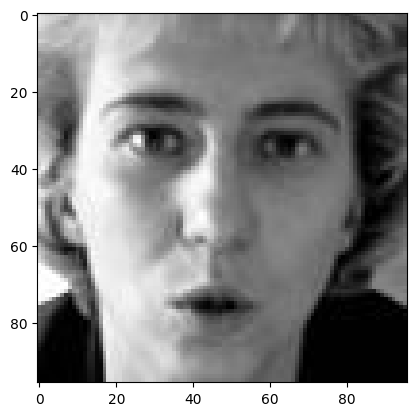

In [ ]:
# Load the .npz file from the drive for preparation of the data to training and testing
data_save_directory ="/content/drive/MyDrive/keypoint_detection/images/" # npz file
loaded_data = np.load(data_save_directory+'processed_keypoint_data.npz')

# Access images and labels from loaded data
loaded_images = loaded_data['images']
loaded_keypoints = loaded_data['keypoints']

# Validation of the images and corresponding keypoints through visualization of random samples
print(loaded_images.shape, loaded_keypoints.shape)
print(type(loaded_images), type(loaded_keypoints))
print(loaded_keypoints[1, :])
plt.imshow(loaded_images[1,:,:,:].reshape(96, 96, 3))


# **Preparing the Train, Val, Test Split (train = 0.8, validation  = 0.1, test = 0.1)**
Total samples = 7049,
Train = 5639,
Validation = 705,
Test = 705

In [ ]:
# Splitting the dataset into train validation and test (train = 0.8, validation  = 0.1, test = 0.1)

# Split the data into training, validation, and testing sets
train_data, temp_data, train_keypoints, temp_keypoints = train_test_split(
    loaded_images, loaded_keypoints, test_size=0.2, random_state=42
)

# Further split the remaining data into validation and test sets
validation_data, test_data, validation_keypoints, test_keypoints = train_test_split(
    temp_data, temp_keypoints, test_size=0.5, random_state=42
)

# train_data, validation_data, and test_data along with
# train_keypoints, validation_keypoints, and test_keypoints to train,
# validate, and test neural network

In [ ]:
print('shape of images (Train,Val, Test):',train_data.shape, validation_data.shape, test_data.shape)
print('shape of keypoints (Train,Val, Test):',train_keypoints.shape, validation_keypoints.shape, test_keypoints.shape)

shape of images (Train,Val, Test): (5639, 96, 96, 3) (705, 96, 96, 3) (705, 96, 96, 3)
shape of keypoints (Train,Val, Test): (5639, 30) (705, 30) (705, 30)


# **Neural network for keypoint detection**

In [ ]:
### Network configurable parameters
# image size is 96*96*3 and there are 30 keypoints (columns in labels)

params = {'input_shape': (96,96,3), 'num_keypoints': 30, 'learning_rate': 1e-5,
          'loss': 'mean_squared_error', 'metric': ['mae']}

In [ ]:
# neural network for the keypoint detection
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Squeeze-and-Excitation Network block (SENet)
def se_block(input_tensor, ratio=8):
    channels = input_tensor.shape[-1]

    # Squeeze operation (Global Average Pooling)
    squeeze = layers.GlobalAveragePooling2D()(input_tensor)

    # Excitation operation (Fully connected layers)
    excitation = layers.Dense(channels // ratio, activation='relu')(squeeze)
    excitation = layers.Dense(channels, activation='sigmoid')(excitation)

    # Reshape for multiplication
    excitation = layers.Reshape((1, 1, channels))(excitation)

    # Scale the input tensor
    scaled_input = layers.Multiply()([input_tensor, excitation])

    # add a shortcut connection
    output_tensor = layers.Add()([input_tensor, scaled_input])

    return output_tensor

# SENet keypoint detection network
def se_keypoint_detection_net(input_shape, num_keypoints):
    input_layer = tf.keras.Input(shape=input_shape, name='input_image')
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)

    # SENet block after the first convolutional layer
    x = se_block(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # SENet block after the second convolutional layer
    x = se_block(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # SENet block after the third convolutional layer
    x = se_block(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    output_layer = layers.Dense(num_keypoints, activation='linear')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model


# **Model compilation and summary and visualization of the model**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 94, 94, 32)           896       ['input_image[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 global_average_pooling2d (  (None, 32)                   0         ['max_pooling2d[0][0]']   

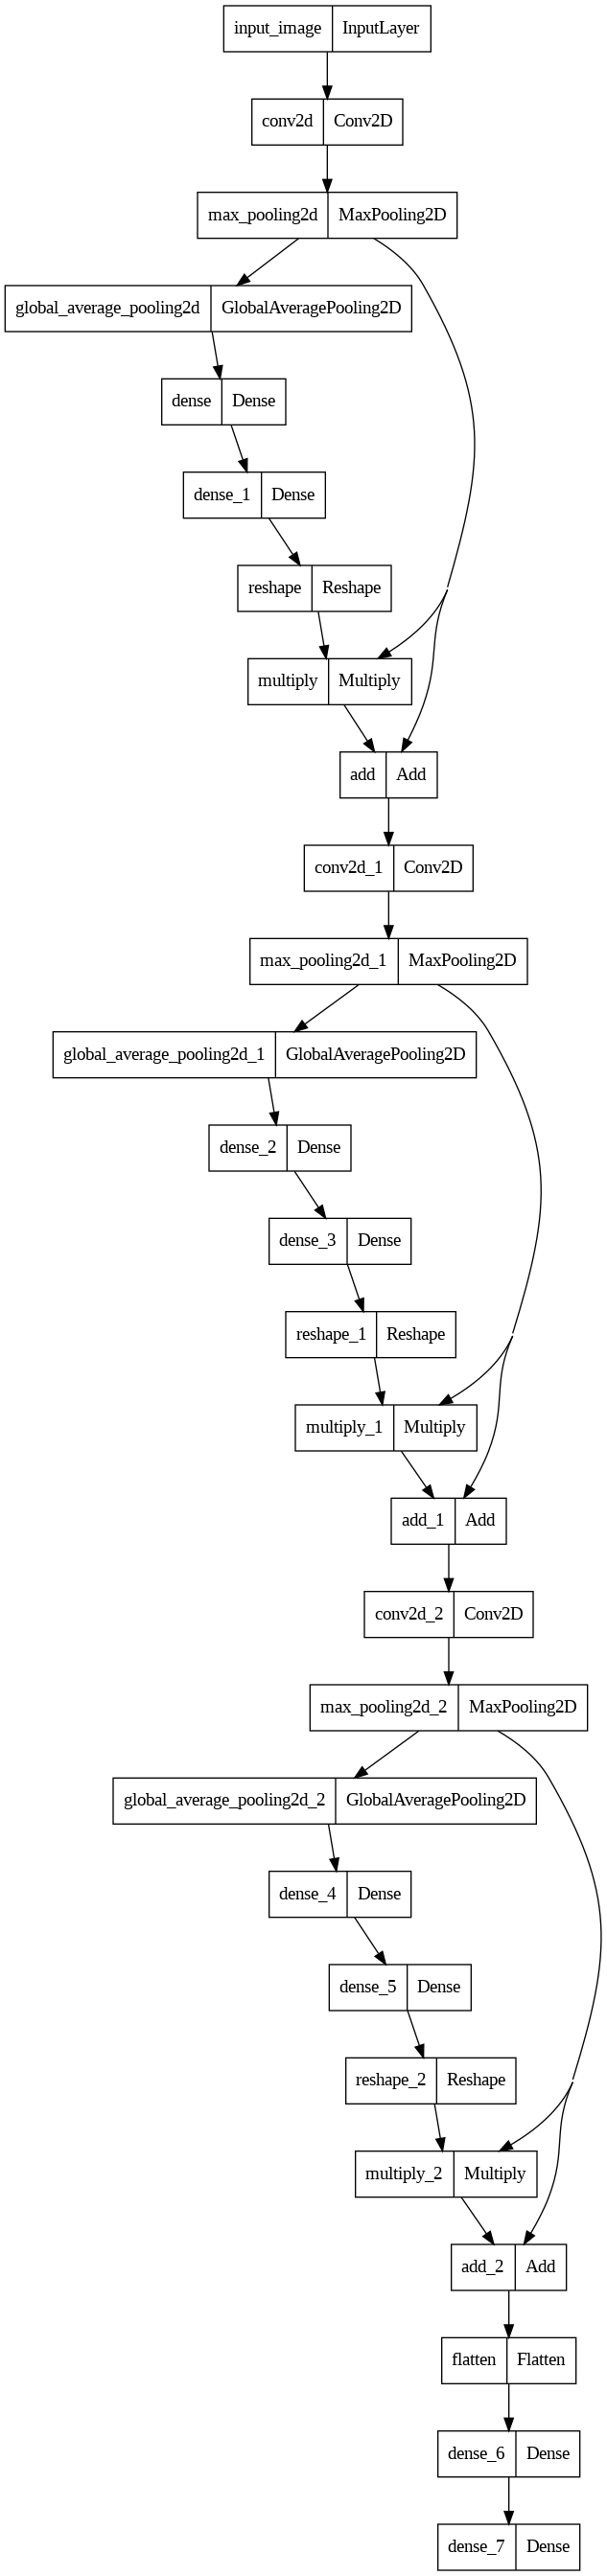

In [ ]:
# calling model and compile and summary
model = se_keypoint_detection_net(params['input_shape'], params['num_keypoints'])
# Compile the model (with optimizer = adam , loss = meas squared error and metrics = mean_absolute_error)
model.compile(optimizer=  Adam(learning_rate=params['learning_rate']), loss=params['loss'],
              metrics=params['metric'])

# Display the model summary
model.summary()
save_path = '/content/drive/MyDrive/keypoint_detection/model_results/model_v1/'

def myprint(s):
    with open(save_path+'model_v1_summary.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=myprint)
tf.keras.utils.plot_model(model, to_file=save_path+'model_v1_plot.png')

# **Model training, loss plotting and saving the trained model**

Epoch 1/200
177/177 [==============================] - 12s 19ms/step - loss: 316.7407 - mae: 11.8562 - val_loss: 127.6106 - val_mae: 8.6763
Epoch 2/200
177/177 [==============================] - 3s 16ms/step - loss: 95.1105 - mae: 7.4402 - val_loss: 82.7670 - val_mae: 6.9548
Epoch 3/200
177/177 [==============================] - 3s 14ms/step - loss: 60.9350 - mae: 5.9627 - val_loss: 55.1263 - val_mae: 5.6289
Epoch 4/200
177/177 [==============================] - 3s 14ms/step - loss: 43.7876 - mae: 5.0610 - val_loss: 42.4017 - val_mae: 4.9157
Epoch 5/200
177/177 [==============================] - 3s 14ms/step - loss: 34.4522 - mae: 4.4796 - val_loss: 34.8521 - val_mae: 4.4505
Epoch 6/200
177/177 [==============================] - 3s 17ms/step - loss: 28.7457 - mae: 4.0909 - val_loss: 30.0836 - val_mae: 4.1148
Epoch 7/200
177/177 [==============================] - 4s 23ms/step - loss: 25.3357 - mae: 3.8376 - val_loss: 27.5083 - val_mae: 3.9360
Epoch 8/200
177/177 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


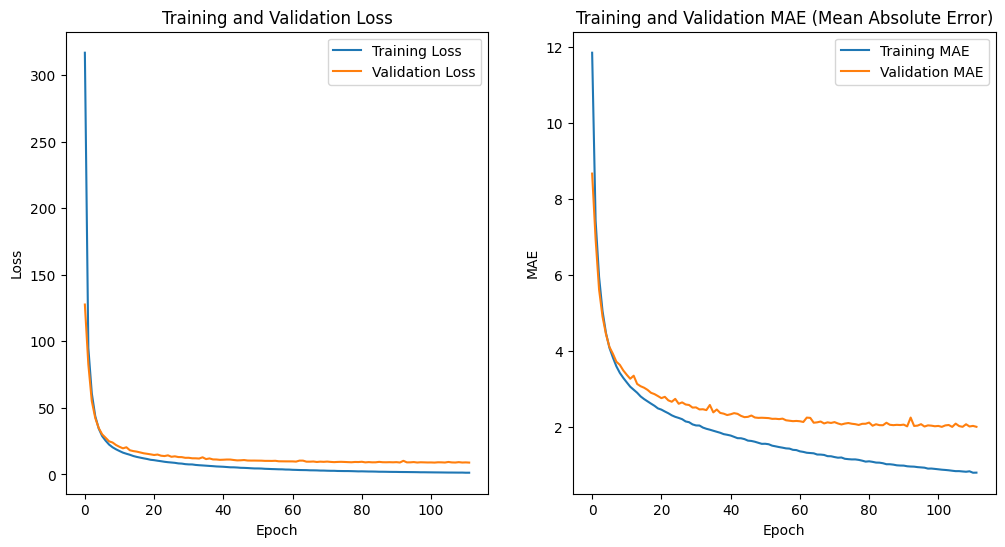

In [ ]:
# Train network
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history= model.fit(
    train_data, train_keypoints,
    epochs=200,
    batch_size=32,
    validation_data=(validation_data, validation_keypoints),
    callbacks=[early_stopping]
)


# Save the model
model.save(save_path+'trained_model_v1_keypoint_detection.h5')

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# # Save the training and validation loss plot
# plt.savefig(save_path+'training_validation_loss_plot.png')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Save the training and validation accuracy plot
plt.savefig(save_path+'training_validation_loss_plot.png')
plt.show()
plt.close()

# **Trained model loading and predictions saving in CSV file**

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
save_path = '/content/drive/MyDrive/keypoint_detection/model_results/model_v1/'
model = load_model(save_path+'model_v1_keypoint_detection.h5')

# Predict keypoints on test data
predictions = model.predict(test_data)

# # Create a DataFrame to store the results
# colums as per the training keypoints data
columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']
results_df = pd.DataFrame(predictions, columns= columns)

# # Save results to CSV
results_df.to_csv(save_path+'model_v1_keypoint_predictions.csv', index=False)

23/23 [==============================] - 0s 4ms/step


# **Visualization of sample images with GT and predicted keypoints**

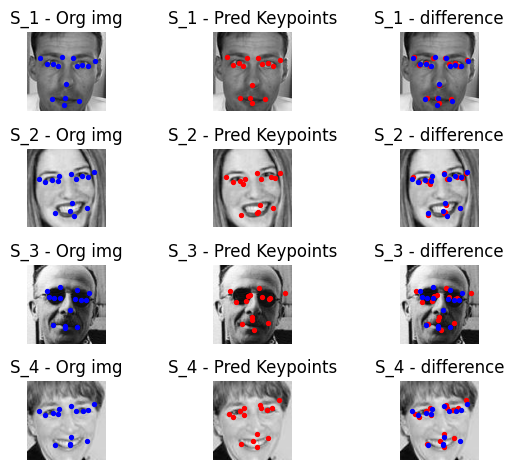

In [ ]:
# Visualize random samples and the keypoint results with ground truth
num_samples = 4
sample_indices = np.random.choice(len(test_data), num_samples, replace=False)

for i, sample_index in enumerate(sample_indices):
    sample_image = test_data[sample_index]
    sample_prediction = predictions[sample_index]
    test_keys = test_keypoints[sample_index]

    # Plot the original image
    plt.subplot(num_samples, 3, 3*i+1)
    plt.imshow(sample_image)
    plt.scatter(test_keys[0::2], test_keys[1::2], color='blue', marker='o', s=8)
    plt.title(f'S_{i+1} - Org img')
    plt.axis('off')

    # Plot the image with predicted keypoints
    plt.subplot(num_samples, 3, 3*i+2)
    plt.imshow(sample_image)
    plt.scatter(sample_prediction[0::2], sample_prediction[1::2], color='red', marker='o', s=8)
    plt.title(f'S_{i+1} - Pred Keypoints')
    plt.axis('off')

     # Plot the image with predicted keypoints
    plt.subplot(num_samples, 3, 3*i+3)
    plt.imshow(sample_image)
    plt.scatter(sample_prediction[0::2], sample_prediction[1::2], color='red', marker='o', s=8)
    plt.scatter(test_keys[0::2], test_keys[1::2], color='blue', marker='o', s=8)
    plt.title(f'S_{i+1} - difference')
    plt.axis('off')

plt.tight_layout()
plt.savefig(save_path+'model_v1_results_1.png')
plt.show()


In [ ]:
print(predictions.shape)
print(test_keypoints.shape)
print(sample_indices)
print(predictions[0])

(705, 30)
(705, 30)
[130 446 117 164]
[64.79762  36.139957 29.685078 35.612637 57.66522  36.741264 72.09179
 35.469154 37.173798 42.59819  22.635492 40.795563 52.68679  27.483624
 82.053986 27.073387 38.300846 34.739025 10.539006 38.56679  49.68697
 66.34618  76.0567   73.439125 31.629215 78.58115  55.102825 73.74835
 49.159245 74.2105  ]


# **Model perfromance evaluation using MAE**

In [ ]:
# measuring the perfromance metrics in terms of MSE and MAE
# A lower MSE indicates better accuracy
# A lower MAE indicates better accuracy.
from sklearn.metrics import mean_absolute_error

# Function to evaluate the performance of the model and return dataframe
def evaluate_keypoint_detection_performance(test_keypoints, predictions):
  # test_keypoints (ground truth) and predictions
  # Flatten the arrays to simplify the calculations
  test_keypoints_flat = test_keypoints.flatten() # Ground truth keypoints
  predictions_flat = predictions.flatten() # Predicted keypoints

  # Calculate Mean Absolute Error (MAE)
  mae = mean_absolute_error(test_keypoints_flat, predictions_flat)
  print(f'Mean Absolute Error: {round(mae,3)}')

  # thresholds for accuracy calculation
  thresholds = [5, 10, 15]  # threshold is x- pixel distance are considered as accurate
  mae_dict = {}
  for threshold in thresholds:
    # Calculate accuracy based on the threshold
    accuracy_percentage_mae = np.mean(np.abs(predictions - test_keypoints) < threshold) * 100
    mae_dict[f'MAE_threshold_pixels_{threshold}_in%'] = [round(accuracy_percentage_mae,3)]
    print(f'Accuracy Percentage (MAE)_threshold_{threshold}: {round(accuracy_percentage_mae,3)}%')
  new_dict = {'MAE': [round(mae, 3)], **mae_dict}
  # Create a DataFrame to store the results
  results_df = pd.DataFrame(new_dict)
  return results_df

# calling evaluate function and DataFrame to store the results
out_df = evaluate_keypoint_detection_performance(test_keypoints, predictions)

# Save the results to a CSV file
out_df.to_csv(save_path+'evaluation_results_model_v1_keypoint.csv', index=False)

Mean Absolute Error: 2.023
Accuracy Percentage (MAE)_threshold_5: 92.988%
Accuracy Percentage (MAE)_threshold_10: 99.177%
Accuracy Percentage (MAE)_threshold_15: 99.806%


In [ ]:
out_df.head()

,MAE,MAE_threshold_pixels_5_in%,MAE_threshold_pixels_10_in%,MAE_threshold_pixels_15_in%
0,2.023,92.988,99.177,99.806
